<h2>Imports</h2>

In [1]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

<h2>Preprocessing</h2>

In [2]:
df = pd.read_csv('individual_bank_data.csv')

In [3]:
df.head()

Date      Index         Open         High          Low        Close
0  2023-01-02  HDFC Bank  1622.050049  1639.000000  1618.650024  1629.150024
1  2023-01-03  HDFC Bank  1624.550049  1643.599976  1624.550049  1639.699951
2  2023-01-04  HDFC Bank  1635.000000  1645.750000  1607.449951  1610.550049
3  2023-01-05  HDFC Bank  1614.300049  1618.199951  1590.000000  1599.699951
4  2023-01-06  HDFC Bank  1599.750000  1608.900024  1578.500000  1594.349976

In [4]:
summary_stats = df.describe()
summary_stats

Open         High          Low        Close
count  2760.000000  2760.000000  2760.000000  2760.000000
mean    713.186311   719.292042   706.165200   712.836036
std     590.505681   594.732548   585.637656   590.290765
min      44.759998    45.750000    44.410000    44.919998
25%     156.950001   158.987499   153.724998   156.312496
50%     605.875000   611.450012   599.174988   605.225006
75%    1076.424957  1089.425018  1058.125000  1075.075043
max    1980.949951  2063.000000  1955.000000  1994.599976

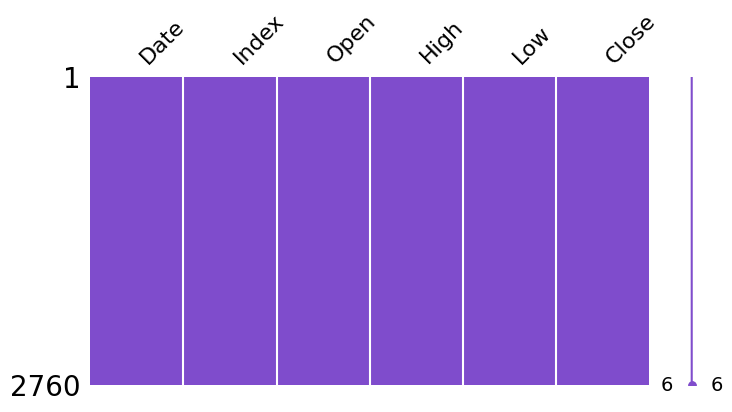

In [5]:
import missingno as msno
df = pd.read_csv('individual_bank_data.csv')
msno.matrix(df , color=(0.50,0.30,0.80),figsize=(8, 4))
plt.show()
x = df.isnull().sum()
for a, b in x.items():
 if b > 0:
     print(f"There are {b} missing values in column: {a}")

In [31]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.strftime('%Y-%m')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.to_period('Q').astype(str)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [41]:
# Convert 'Date' to datetime format

df['Daily_Return'] = df.groupby('Index')['Close'].pct_change()
df['10_MA'] = df.groupby('Index')['Close'].transform(lambda x: x.rolling(window=10).mean())
df['30_MA'] = df.groupby('Index')['Close'].transform(lambda x: x.rolling(window=30).mean())
df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod()
df['Volatility_14d'] = df.groupby('Index')['Daily_Return'].transform(lambda x: x.rolling(window=14).std())
df['High-Low Range'] = df['High'] - df['Low']
df['Price_Range'] = df['High'] - df['Low']
df['Volatility'] = df.groupby('Index')['Close'].transform(lambda x: x.rolling(window=10).std())
df['Yearly ROI (%)'] = df.groupby('Index')['Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)
df['20 Day MA'] = df.groupby('Index')['Close'].transform(lambda x: x.rolling(window=20).mean())
df['20 Day Std'] = df.groupby('Index')['Close'].transform(lambda x: x.rolling(window=20).std())
df['Upper Band'] = df['20 Day MA'] + (df['20 Day Std'] * 2)
df['Lower Band'] = df['20 Day MA'] - (df['20 Day Std'] * 2)

<h2>Visualization</h2>

<h3>Mean Price Stats for Banks</h3>

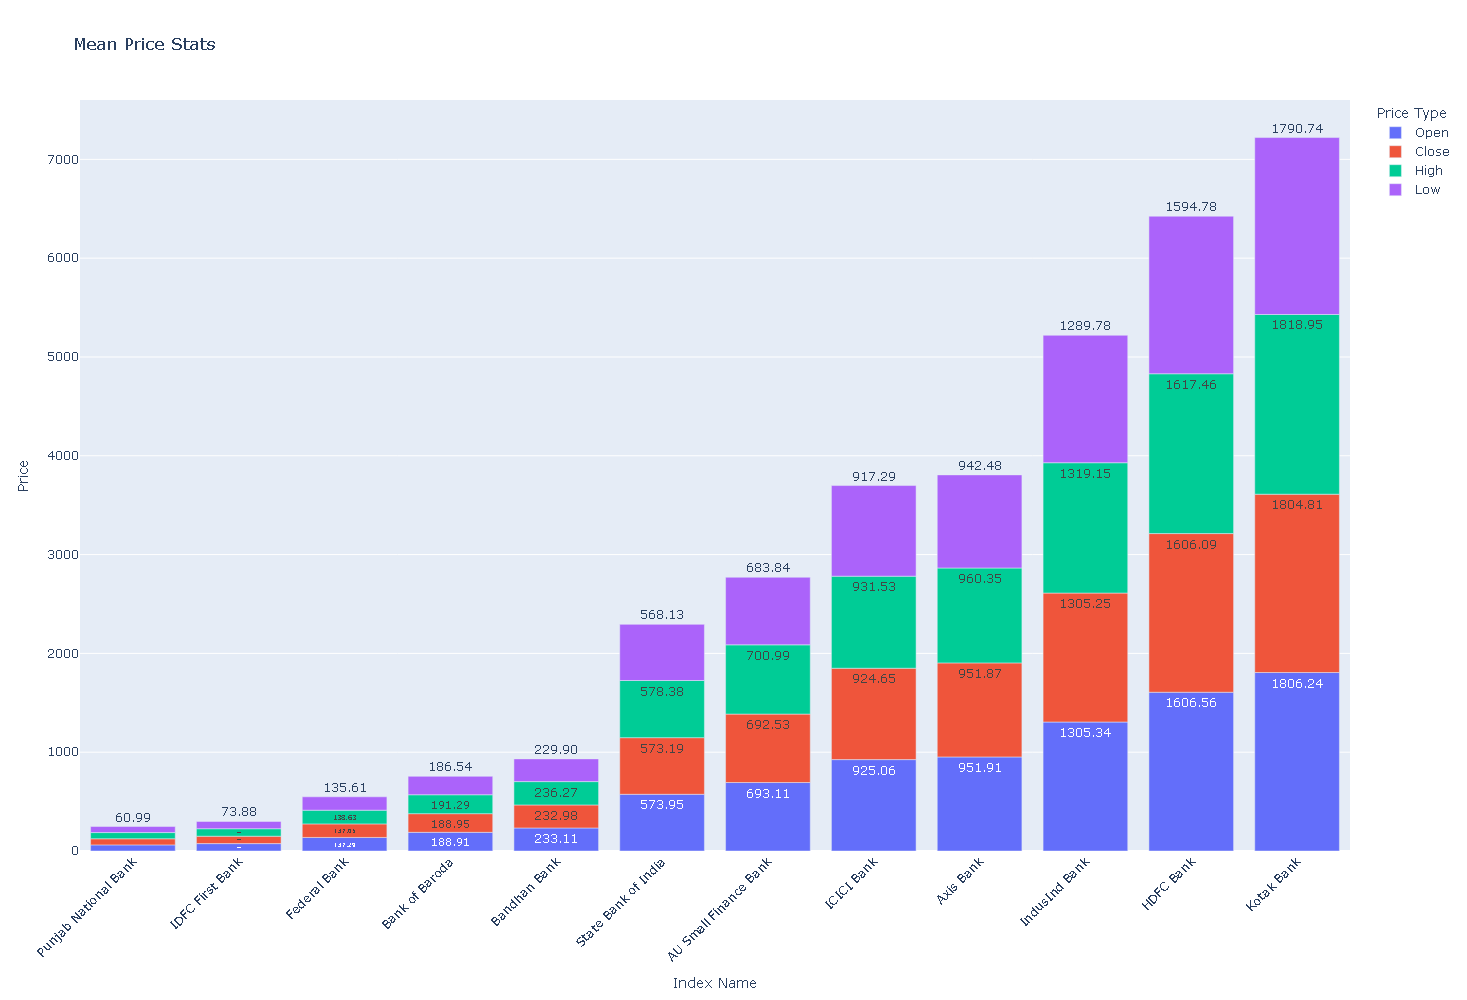

In [35]:
#Getting mean statistic
mean_stats = df.groupby('Index')[['Open', 'Close', 'High', 'Low']].mean().sort_values(by='Close')

# Resetting index for Plotly
mean_stats.reset_index(inplace=True)

# Melt the DataFrame for Plotly
mean_stats_melted = mean_stats.melt(id_vars='Index', value_vars=['Open', 'Close', 'High', 'Low'], 
                                      var_name='Price Type', value_name='Price')

# Plotting
fig = px.bar(mean_stats_melted, x='Index', y='Price', color='Price Type',
             title='Mean Price Stats',
             labels={'Price': 'Price', 'Index': 'Index Name'},
             text='Price')

# Show values on bars
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

# Customize layout
fig.update_layout(xaxis_tickangle=-45,width=1400,height=1000)

# Show the figure
fig.show()

<h3>Price Movement Over Time</h3>

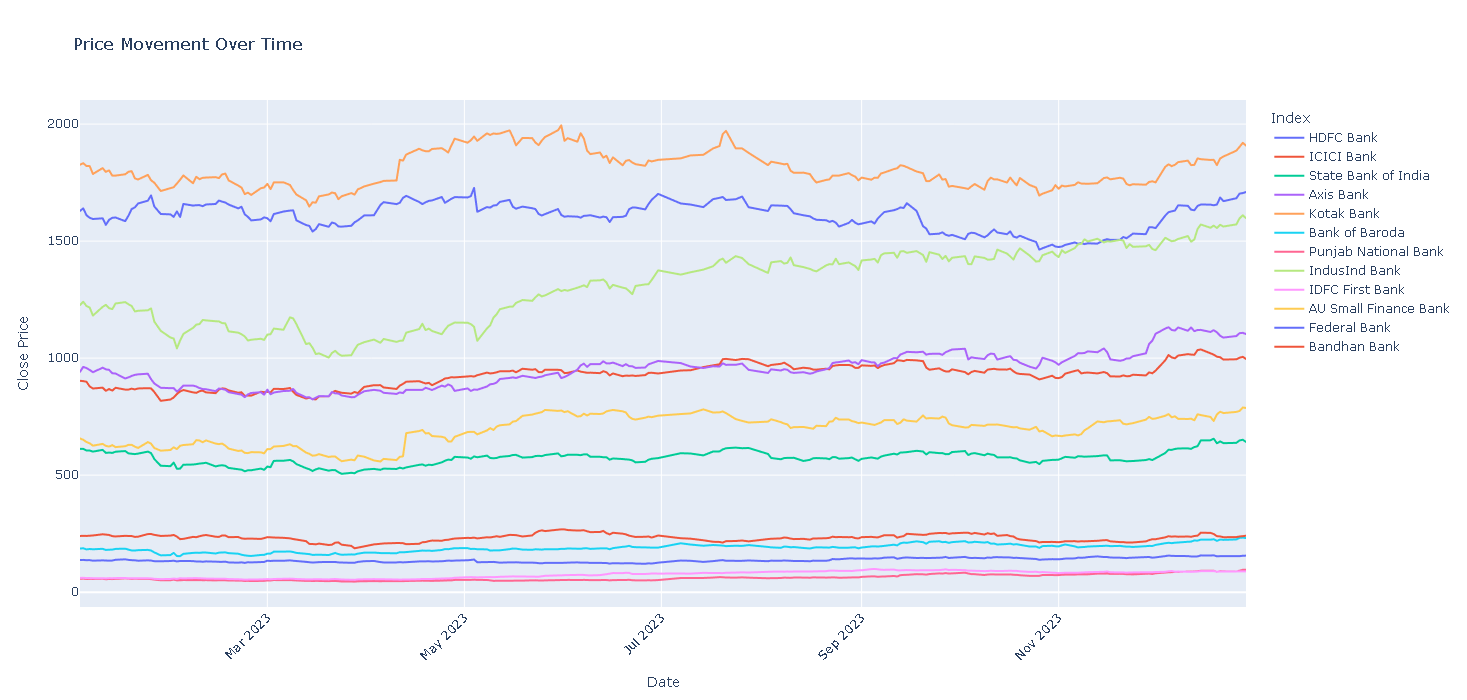

In [45]:
# Create an interactive line plot for price movement over time
fig = px.line(df, x='Date', y='Close', color='Index', title='Price Movement Over Time')

# Update the layout to match the original plot style
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Close Price',
    xaxis_tickangle=-45,
    legend_title='Index',
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=1200),
    width=1400,
    height=700
)

# Show the interactive plot
fig.show()


<h3>Monthly Average Daily Returns</h3>

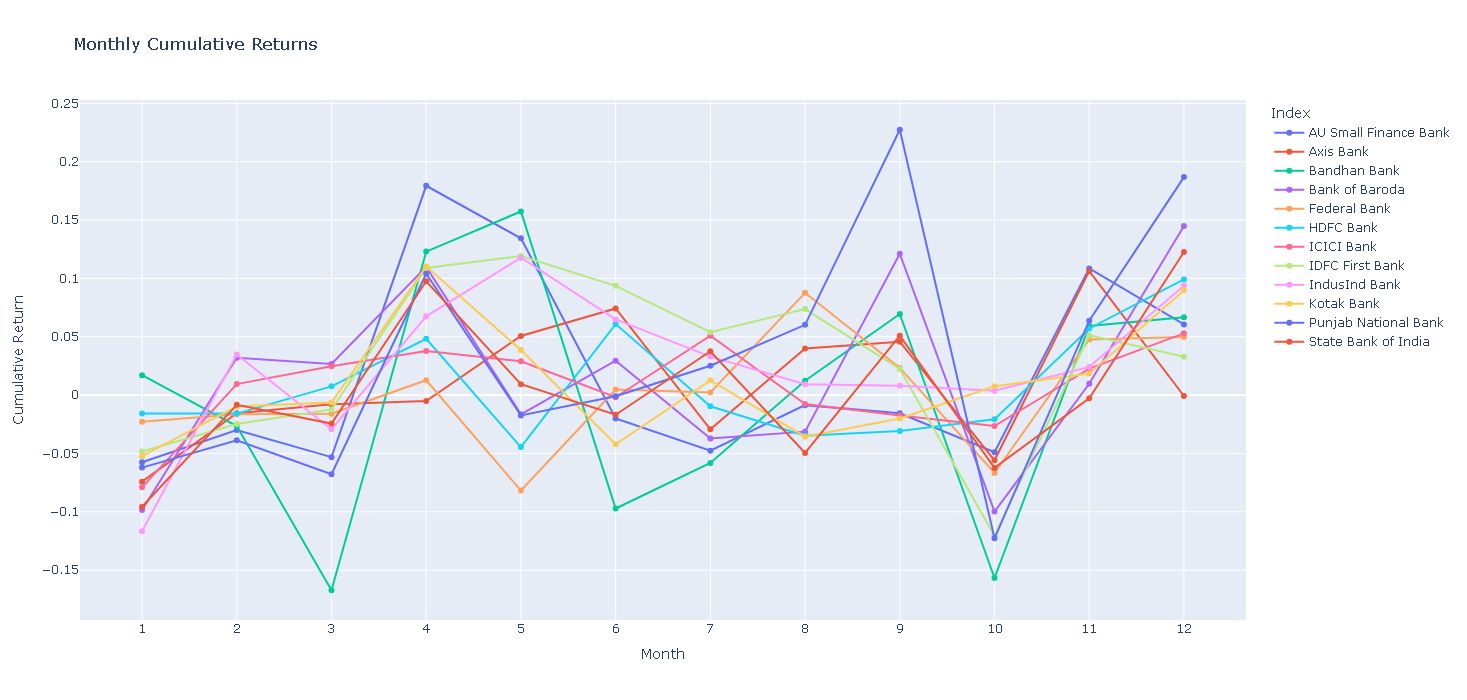

In [44]:
# Get the start and end prices for each index and month
monthly_prices = df.groupby(['Index', 'Year', 'Month']).agg(
    Start_Price=('Close', 'first'),  # Price at the beginning of the month
    End_Price=('Close', 'last')      # Price at the end of the month
).reset_index()

# Calculate monthly cumulative returns
monthly_prices['Monthly_Cumulative_Return'] = (monthly_prices['End_Price'] / monthly_prices['Start_Price']) - 1

# Reset index for plotting
monthly_prices['Month'] = monthly_prices['Month'].astype(str)

# Create an interactive plot using Plotly
fig = px.line(
    monthly_prices,
    x='Month',
    y='Monthly_Cumulative_Return',
    color='Index',
    title='Monthly Cumulative Returns',
    labels={'Monthly_Cumulative_Return': 'Cumulative Return', 'Month': 'Month'},
    markers=True
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Cumulative Return',
    legend_title='Index',
    xaxis_tickangle=0,
    template='plotly',
    width=1400,
    height=700
)

# Show the plot
fig.show()

<h3>Quarterly Cumulative Returns</h3>

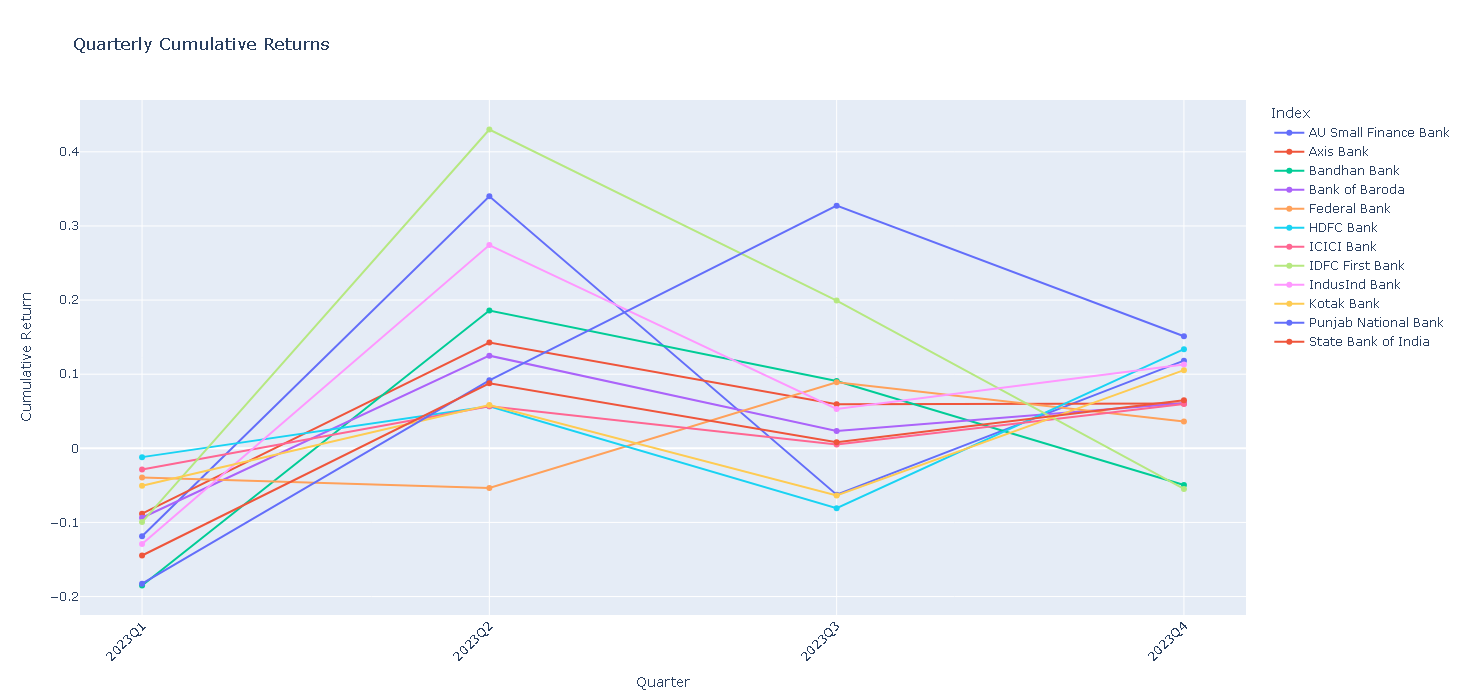

In [46]:
# Get the start and end prices for each index and quarter
quarterly_prices = df.groupby(['Index', 'Year', 'Quarter']).agg(
    Start_Price=('Close', 'first'),  # Price at the beginning of the quarter
    End_Price=('Close', 'last')      # Price at the end of the quarter
).reset_index()

# Calculate quarterly cumulative returns
quarterly_prices['Quarterly_Cumulative_Return'] = (quarterly_prices['End_Price'] / quarterly_prices['Start_Price']) - 1

# Reset index for plotting
quarterly_prices['Quarter'] = quarterly_prices['Quarter'].astype(str)

# Create an interactive plot using Plotly
fig = px.line(
    quarterly_prices,
    x='Quarter',
    y='Quarterly_Cumulative_Return',
    color='Index',
    title='Quarterly Cumulative Returns',
    labels={'Quarterly_Cumulative_Return': 'Cumulative Return', 'Quarter': 'Quarter'},
    markers=True
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Quarter',
    yaxis_title='Cumulative Return',
    legend_title='Index',
    xaxis_tickangle=-45,
    template='plotly',
    width=1400,
    height=700
)

# Show the plot
fig.show()


<h3>Moving Average</h3>

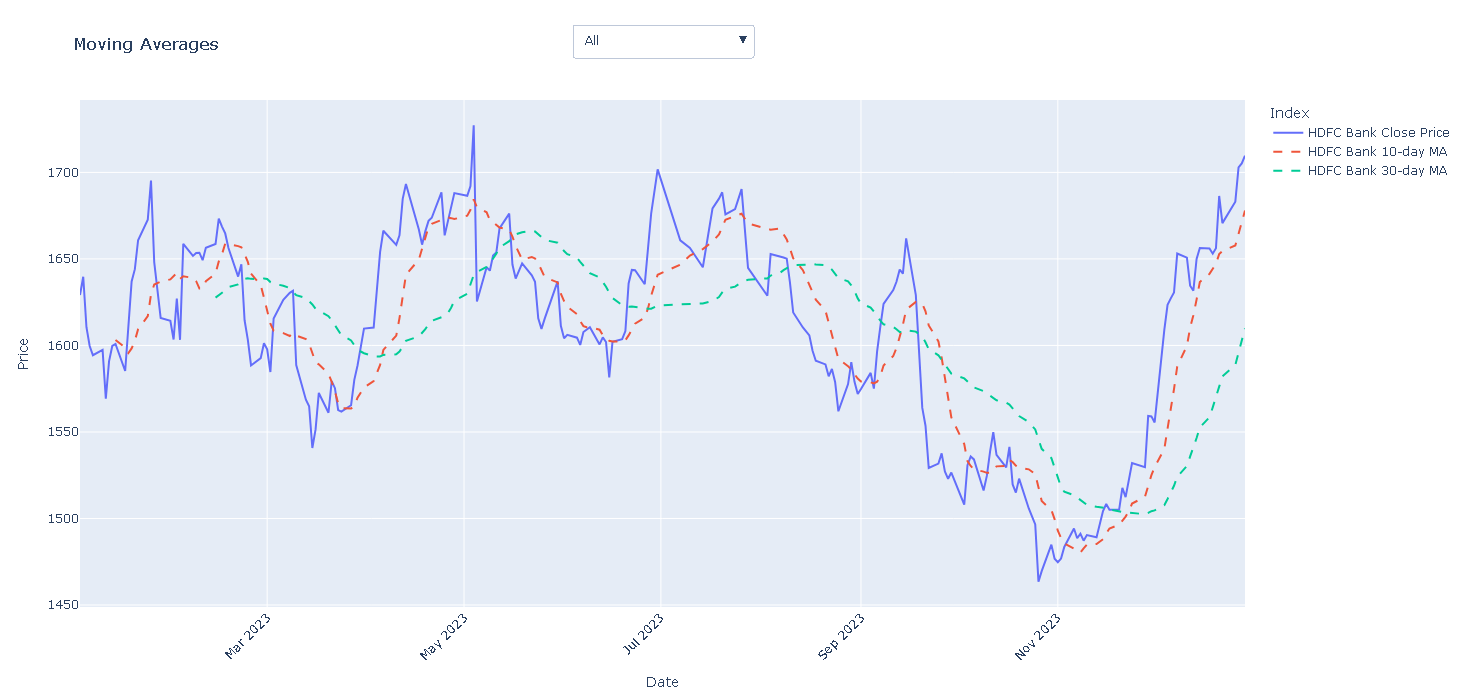

In [47]:
# Get unique indices
unique_indices = df['Index'].unique()

# Create a Plotly figure
fig = go.Figure()

# Add traces for each bank index
for bank in unique_indices:
    bank_data = df[df['Index'] == bank]
    
    # Close Price
    fig.add_trace(go.Scatter(x=bank_data['Date'], y=bank_data['Close'], mode='lines', name=f'{bank} Close Price', visible=False))
    
    # 10-day MA
    fig.add_trace(go.Scatter(x=bank_data['Date'], y=bank_data['10_MA'], mode='lines', name=f'{bank} 10-day MA', line=dict(dash='dash'), visible=False))
    
    # 30-day MA
    fig.add_trace(go.Scatter(x=bank_data['Date'], y=bank_data['30_MA'], mode='lines', name=f'{bank} 30-day MA', line=dict(dash='dash'), visible=False))

# Make the first index visible by default
fig.data[0].visible = True
fig.data[1].visible = True
fig.data[2].visible = True

# Update layout with dropdown menu
fig.update_layout(
    title='Moving Averages',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_tickangle=-45,
    updatemenus=[
        {
            'buttons': [
                {
                    'label': 'All',
                    'method': 'update',
                    'args': [{'visible': [True] * len(fig.data)}]  # Show all traces
                },
                *[
                    {
                        'label': bank,
                        'method': 'update',
                        'args': [
                            {
                                'visible': [
                                    True if f"{bank}" in trace.name else False
                                    for trace in fig.data
                                ]
                            }
                        ]
                    }
                    for bank in unique_indices
                ]
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.5,
            'xanchor': 'center',
            'y': 1.15,
            'yanchor': 'top'
        }
    ],
    legend_title='Index',
    width=1400,
    height=700
)

# Show the figure
fig.show()


<h3>Bollinger Bands</h3>

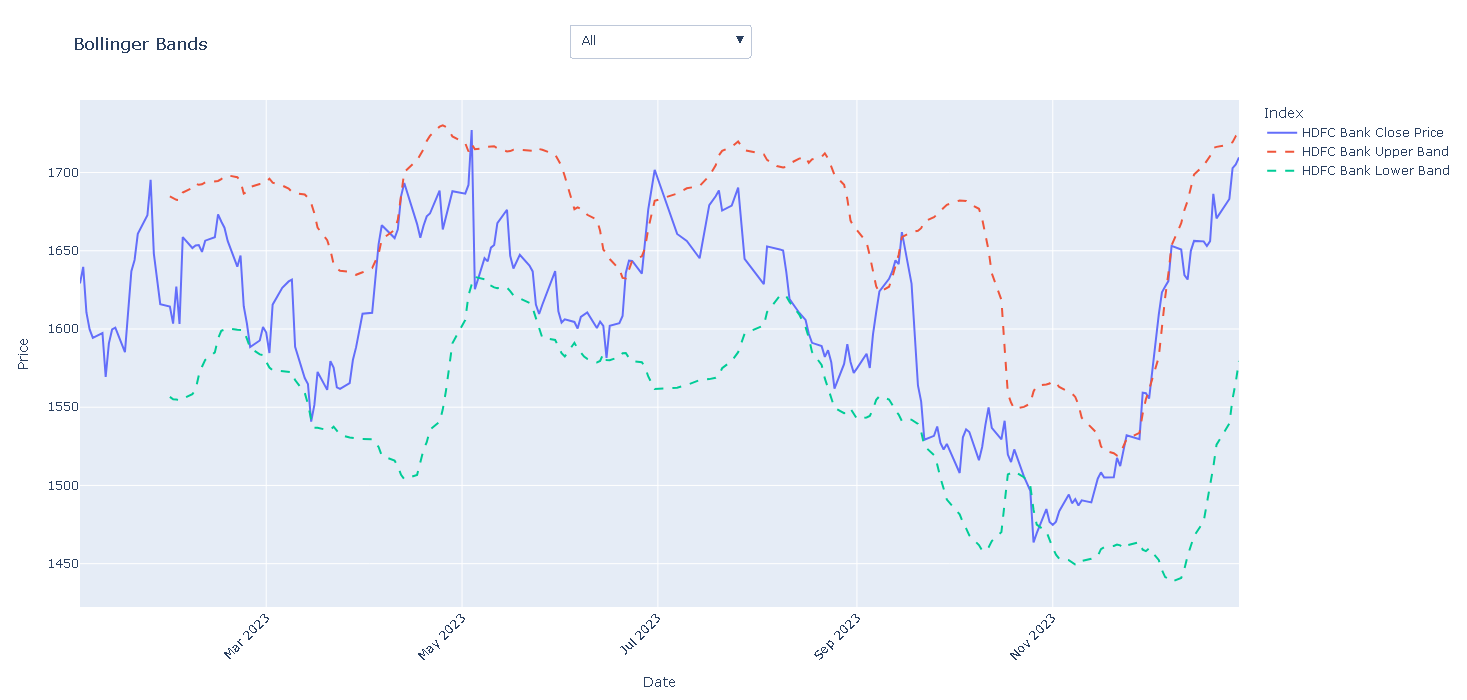

In [48]:
# Get unique indices
unique_indices = df['Index'].unique()

# Create a Plotly figure
fig = go.Figure()

# Add traces for each index
for Index in unique_indices:
    index_data = df[df['Index'] == Index]
    
    # Close Price
    fig.add_trace(go.Scatter(x=index_data['Date'], y=index_data['Close'], mode='lines', name=f'{Index} Close Price', visible=False))
    
    # Upper Band
    fig.add_trace(go.Scatter(x=index_data['Date'], y=index_data['Upper Band'], mode='lines', name=f'{Index} Upper Band', line=dict(dash='dash'), visible=False))
    
    # Lower Band
    fig.add_trace(go.Scatter(x=index_data['Date'], y=index_data['Lower Band'], mode='lines', name=f'{Index} Lower Band', line=dict(dash='dash'), visible=False))

# Make the first index visible by default
fig.data[0].visible = True
fig.data[1].visible = True
fig.data[2].visible = True

# Update layout with dropdown menu
fig.update_layout(
    title='Bollinger Bands',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_tickangle=-45,
    updatemenus=[
        {
            'buttons': [
                {
                    'label': 'All',
                    'method': 'update',
                    'args': [{'visible': [True] * len(fig.data)}]  # Show all traces
                },
                *[
                    {
                        'label': Index,
                        'method': 'update',
                        'args': [
                            {
                                'visible': [
                                    True if f"{Index}" in trace.name else False
                                    for trace in fig.data
                                ]
                            }
                        ]
                    }
                    for Index in unique_indices
                ]
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.5,
            'xanchor': 'center',
            'y': 1.15,
            'yanchor': 'top'
        }
    ],
    legend_title='Index',
    width=1400,
    height=700
)

# Show the figure
fig.show()


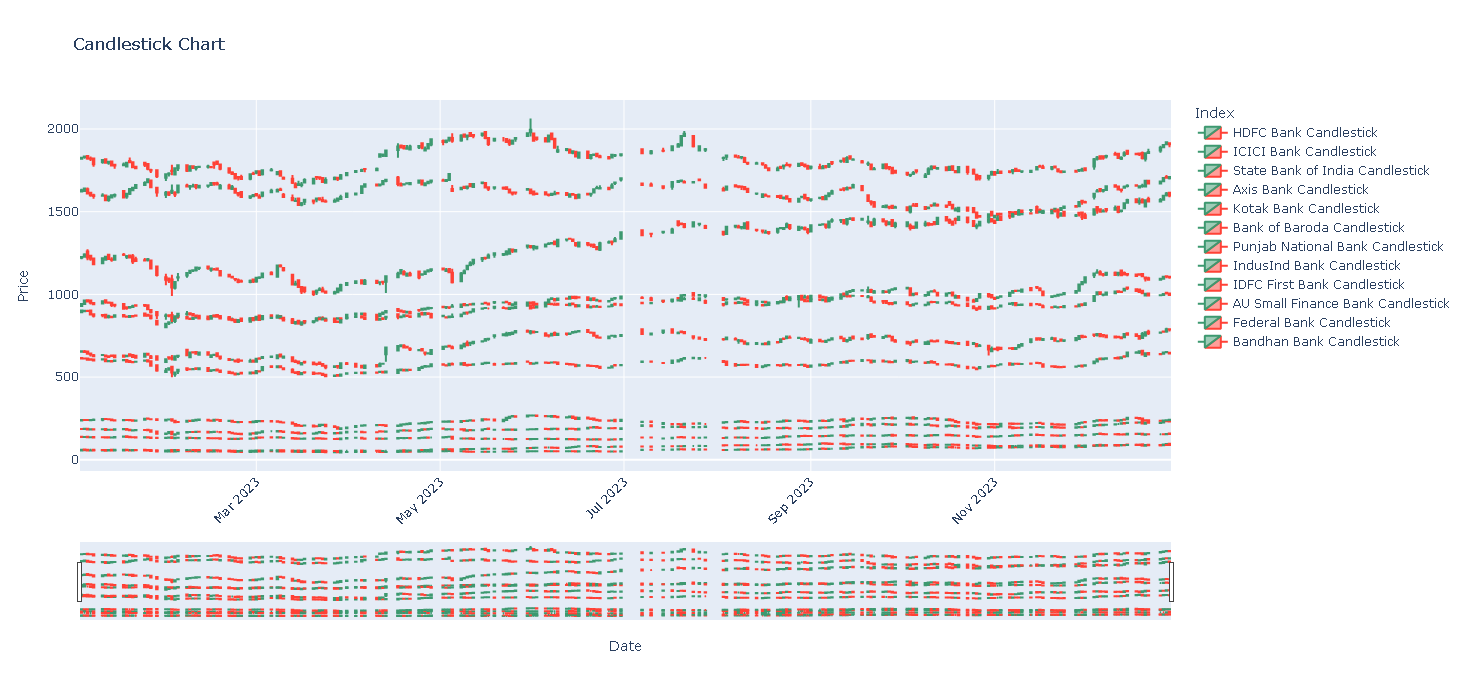

In [49]:
# Get unique indices
unique_indices = df['Index'].unique()

# Create a Plotly figure
fig = go.Figure()

# Add candlestick traces for each index
for index in unique_indices:
    index_data = df[df['Index'] == index]
    
    # Create a candlestick trace
    fig.add_trace(go.Candlestick(
        x=index_data['Date'],
        open=index_data['Open'],
        high=index_data['High'],
        low=index_data['Low'],
        close=index_data['Close'],
        name=f'{index} Candlestick'
    ))

# Update layout
fig.update_layout(
    title='Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_tickangle=-45,
    legend_title='Index',
    width=1400,
    height=700
)

# Show the figure
fig.show()


<h3>Price Correlation Between Banks</h3>

In [15]:
# Create a pivot table to get Close prices for each bank by date
pivot_data = df.pivot_table(values='Close', index='Date', columns='Index')

# Compute the correlation matrix
corr_matrix = pivot_data.corr()

# Create an interactive heatmap
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='Viridis',
    zmin=-1,
    zmax=1,
    colorbar=dict(title='Correlation'),
))

# Update layout
fig.update_layout(
    title='Price Correlation Between Banks',
    xaxis_title='Banks',
    yaxis_title='Banks',
    xaxis=dict(tickangle=-45),
    width=1000,
    height=1000
)

# Show the figure
fig.show()


<h3>Daily Price Volatility</h3>

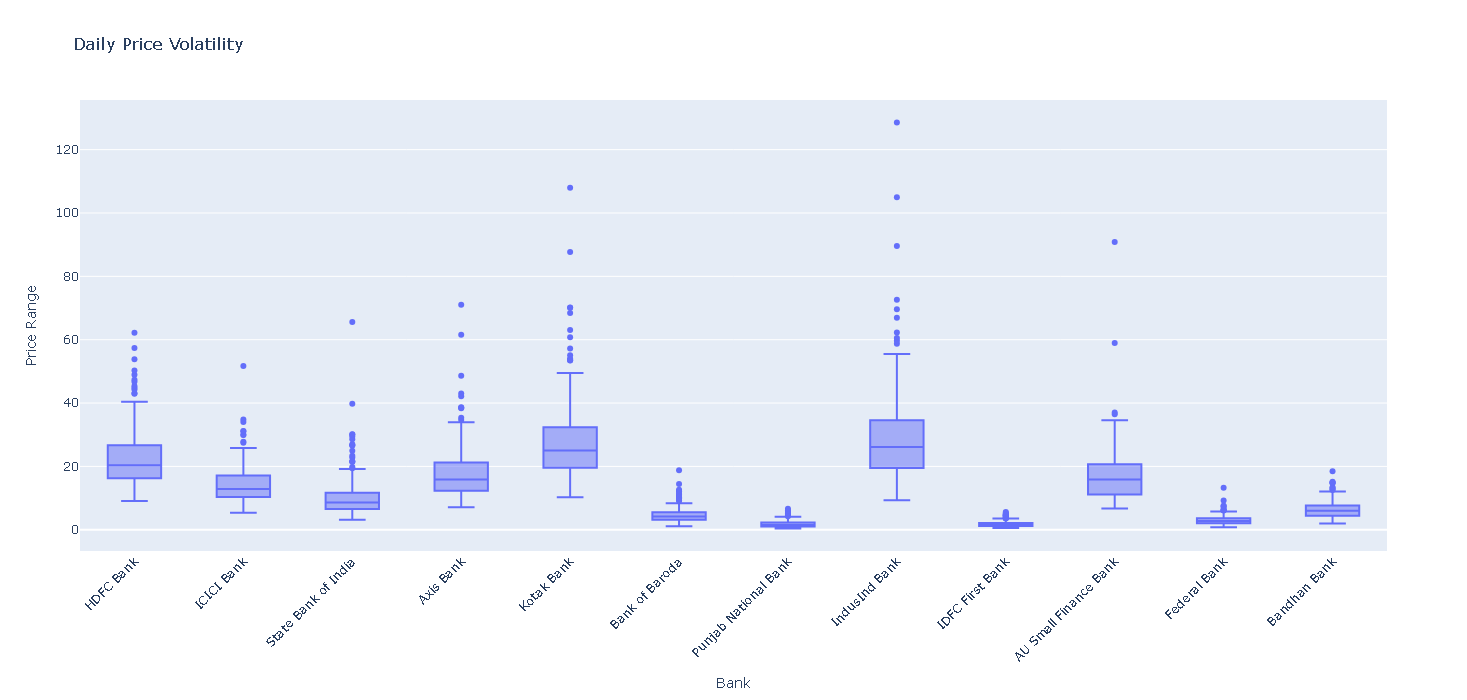

In [69]:
# Create an interactive box plot using Plotly
fig = px.box(
    df,
    x='Index',
    y='Price_Range',
    title='Daily Price Volatility',
    labels={'Price Range': 'Price_Range', 'Index': 'Bank'},
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Bank',
    yaxis_title='Price Range',
    xaxis_tickangle=-45,
    width = 1400,
    height=700,
)

# Show the plot
fig.show()

<h3>Rolling Volatility</h3>

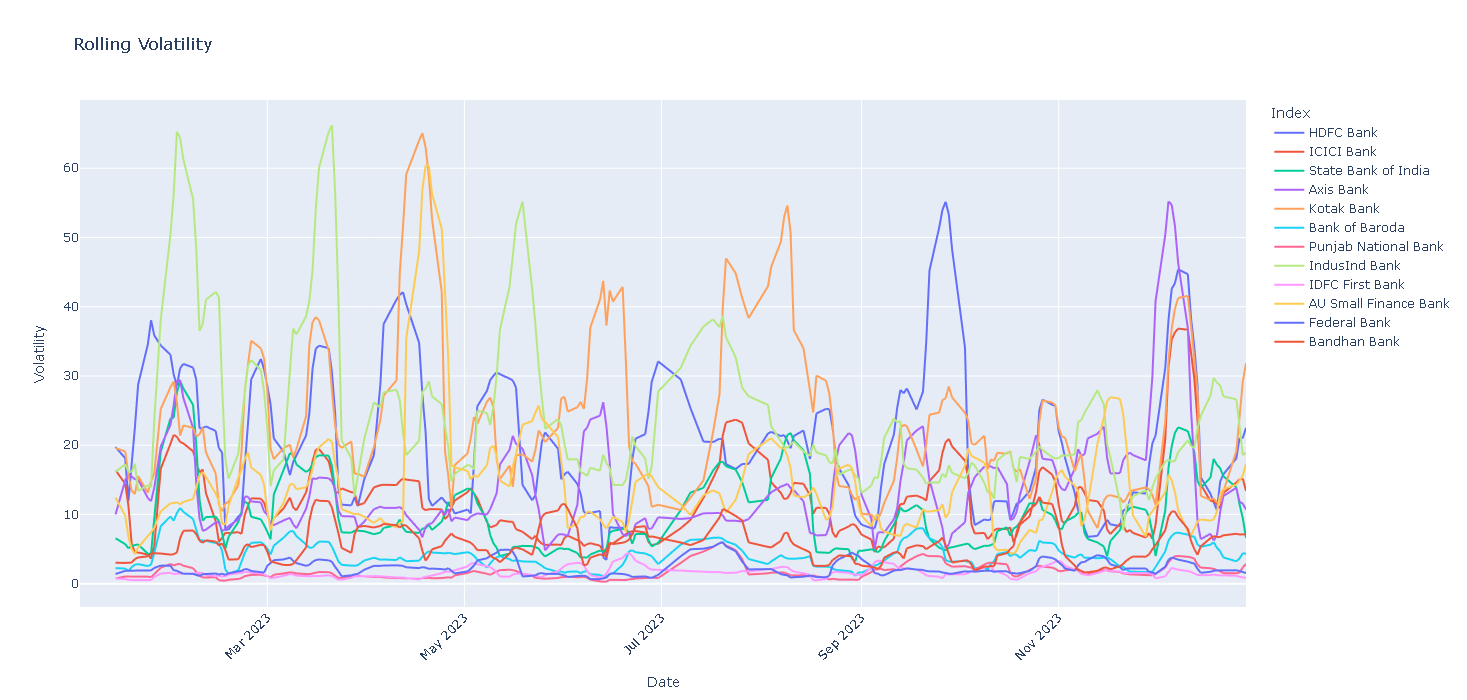

In [50]:
# Create an interactive plot
fig = px.line(df, x='Date', y='Volatility', color='Index',
              title='Rolling Volatility',
              labels={'Volatility': 'Volatility (10-day std)', 'Date': 'Date'})

# Update layout for better readability
fig.update_layout(xaxis_title='Date',
                  yaxis_title='Volatility',
                  legend_title='Index',
                  xaxis_tickangle=-45,
                  width=1400,height=700)

# Show the plot
fig.show()


<h3>Average Daily Price Range</h3>

In [18]:
# Group by 'Index' and calculate the average price range
mean_price_range = df.groupby('Index')['Price_Range'].mean().sort_values()

# Resetting index for Plotly
mean_price_range = mean_price_range.reset_index()

# Plotting
fig = px.bar(mean_price_range, x='Index', y='Price_Range',
             title='Average Daily Price Range',
             labels={'Price_Range': 'Average Price Range', 'Index': 'Index Name'},
             text='Price_Range')

# Show values on bars
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

# Customize layout
fig.update_layout(xaxis_tickangle=-45,width=1400,height=700)

# Show the figure
fig.show()

<h3>Average Monthly High-Low Range Over Time</h3>

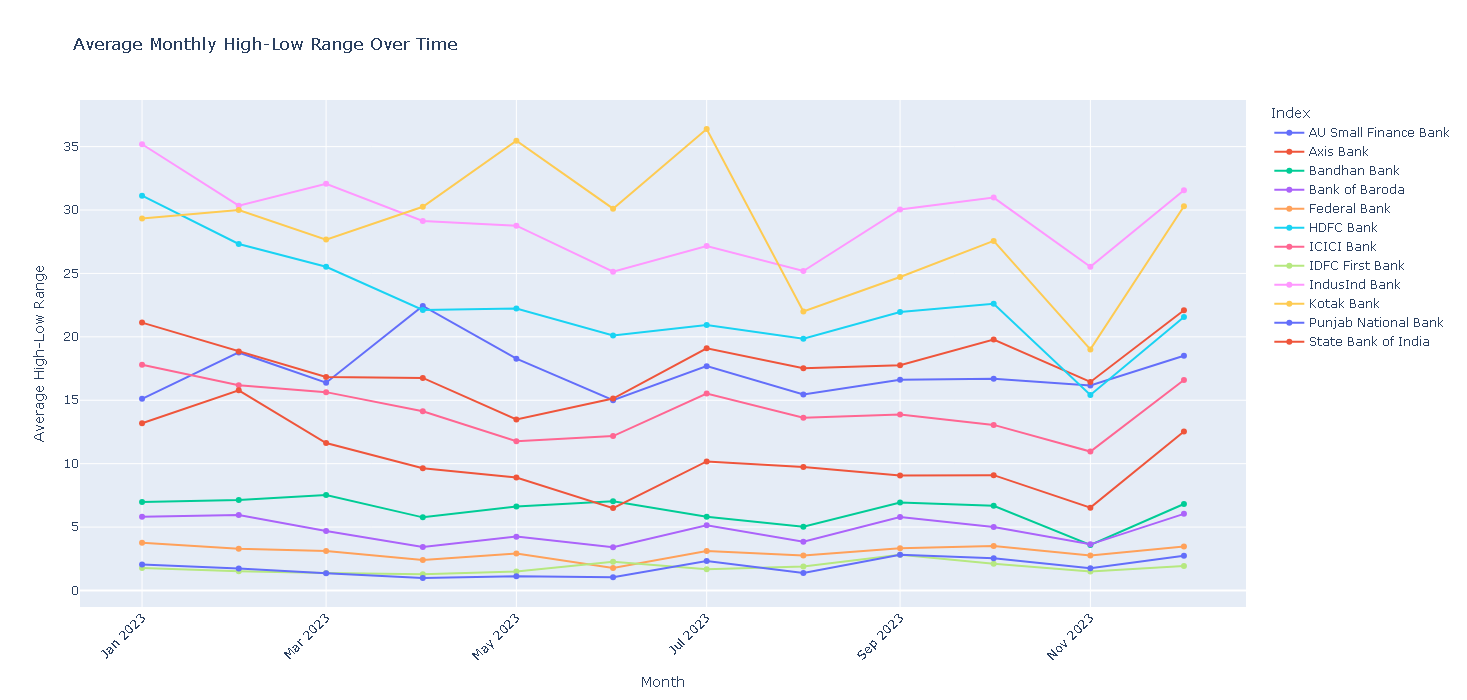

In [25]:
monthly_avg_range = df.groupby(['Index', 'Month'])['High-Low Range'].mean().reset_index()

# Convert the Month column back to datetime for proper plotting
monthly_avg_range['Month'] = monthly_avg_range['Month'].dt.to_timestamp()

# Create an interactive plot using Plotly
fig = px.line(
    monthly_avg_range,
    x='Month',
    y='High-Low Range',
    color='Index',
    title='Average Monthly High-Low Range Over Time',
    labels={'High-Low Range': 'Average High-Low Range', 'Month': 'Month'},
    markers=True
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Average High-Low Range',
    legend_title='Index',
    xaxis_tickangle=-45,
    template='plotly',
    width=1400,
    height=700
)

# Show the plot
fig.show()

<h3>Support and Resistance levels</h3>

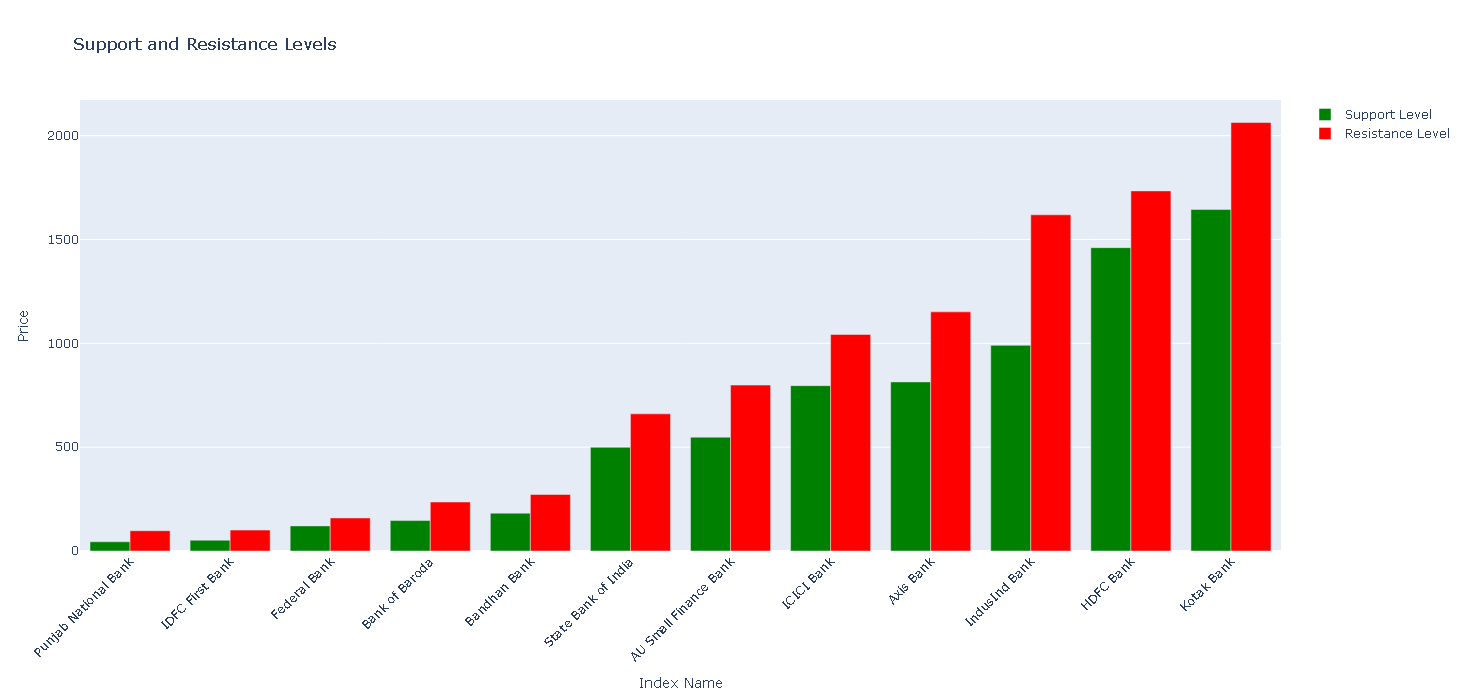

In [59]:
support_levels = df.groupby('Index')['Low'].min()
resistance_levels = df.groupby('Index')['High'].max()

# Sort indices
sorted_indices = support_levels.sort_values().index
sorted_support_levels = support_levels[sorted_indices]
sorted_resistance_levels = resistance_levels[sorted_indices]

# Create an interactive bar plot using Plotly
fig = go.Figure()

fig.add_trace(go.Bar(
    x=sorted_support_levels.index,
    y=sorted_support_levels,
    name='Support Level',
    marker_color='green'
))

# Add resistance level bars
fig.add_trace(go.Bar(
    x=sorted_resistance_levels.index,
    y=sorted_resistance_levels,
    name='Resistance Level',
    marker_color='red'
))

# Add support level bars


# Update layout for better appearance
fig.update_layout(
    title='Support and Resistance Levels',
    xaxis_title='Index Name',
    yaxis_title='Price',
    xaxis_tickangle=-45,
    barmode='group',
    width=1400,
    height=700
)

# Show the plot
fig.show()

<h3>Annual Return On Investment</h3>

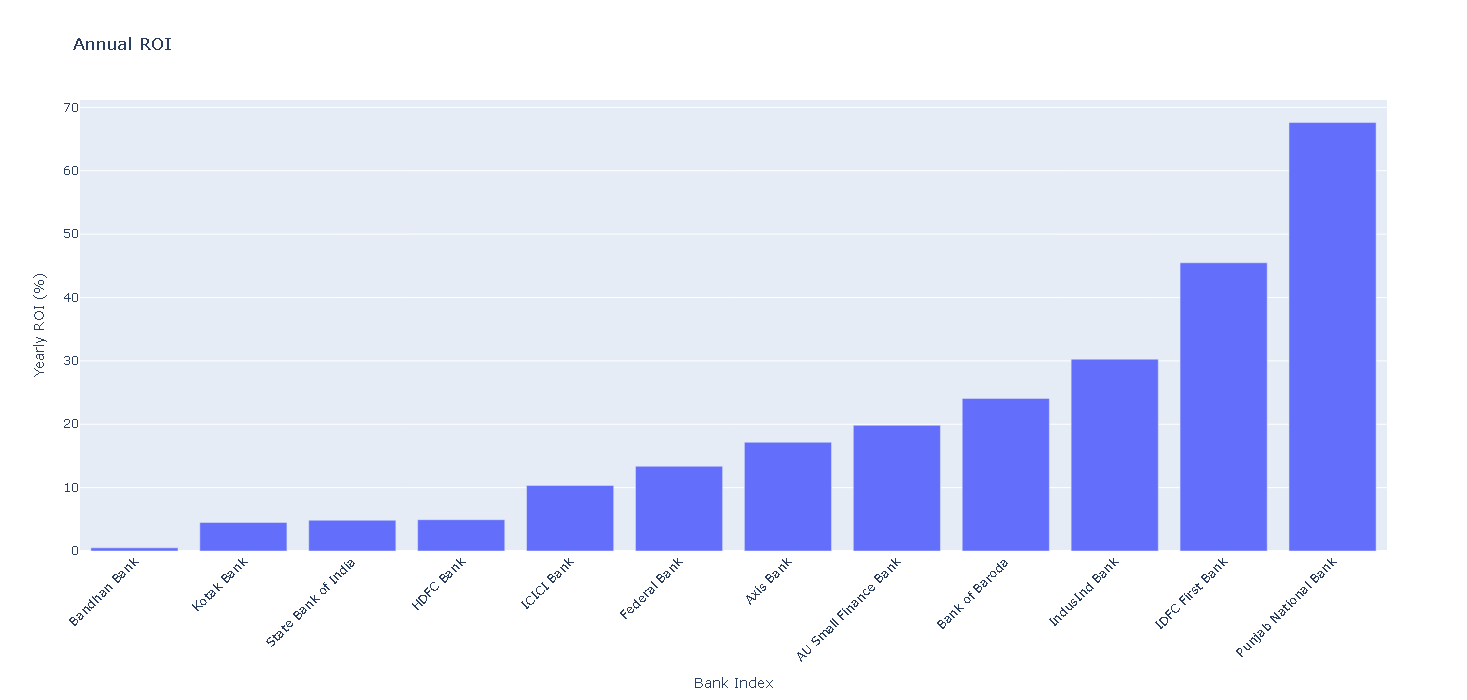

In [60]:
roi_summary = df.groupby('Index')['Yearly ROI (%)'].first().sort_values()

# Create an interactive bar plot using Plotly
fig = px.bar(
    x=roi_summary.index,
    y=roi_summary.values,
    title='Annual ROI',
    labels={'x': 'Bank Index', 'y': 'Yearly ROI (%)'},
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Bank Index',
    yaxis_title='Yearly ROI (%)',
    xaxis_tickangle=-45,
    width = 1400,
    height=700
)

# Show the plot
fig.show()